In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json

In [2]:
curr_dir=os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir,os.pardir))
print(grandparent_dir)
sys.path.append(os.path.join(grandparent_dir))
sys.path.append(os.path.join(grandparent_dir, 'liset_tk'))
print(sys.path)

from liset_aux import ripples_std, middle


c:\Users\Pc\Documents\Tese\LAVA_SNN_ripples
['c:\\nrn\\lib\\python', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\python39.zip', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\DLLs', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples', '', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib\\site-packages', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\Pythonwin', 'c:\\Users\\Pc\\Documents\\Tese\\LAVA_SNN_ripples', 'c:\\Users\\Pc\\Documents\\Tese\\LAVA_SNN_ripples\\liset_tk']


In [3]:
# parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder
# parent=r"E:\neurospark_mat\CNN_TRAINING_SESSIONS"
parent=r"E:\neurospark_mat\Download_from_paper"
bandpass=[100,250]
downsampled_fs = False # Downsampled frequency
factor=downsampled_fs//1000 if downsampled_fs else 30
time_max=60
window_size=0.05
sample_ratio=0.25
scaling_factor=1
refractory=0

In [4]:
dt=1  # Time step in milliseconds (1 ms)


RIPPLE_DETECTION_OFFSET = [18, 45, 31, 20] # it's calculated as 4.5 periods of the ripple wavelet - for 100 Hz and 250 Hz as the limit frequencies
# The Windows for HFO detection are based on the MAX DETECTION OFFSET

#TODO - Why are these values? Can I tune them in a better way?
RIPPLE_CONFIDENCE_WINDOW = int(round(RIPPLE_DETECTION_OFFSET[1] * 1.8)) 

# in timesteps (ms) - Max time from the Insertion Timing to the GT annotation
MAX_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[1]   # in timesteps (ms)

MEAN_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[2]   # in timesteps (ms)

WINDOW_SIZE = int(RIPPLE_DETECTION_OFFSET[1]*4)   # in timesteps (ms) - The size of the window to slice the input data

# unit: timesteps (ms) - The number of steps that 2 consecutive windows must overlap to not lose any relevant CBs

# std, mean = ripples_std(parent) # 61 ms # in seconds
# INTERSECT_WINDOW_LEN=int((std+mean)*1000) # in timesteps (ms) - The size of the intersection window to slice the input data
INTERSECT_WINDOW_LEN=60 # in timesteps (ms) - The size of the intersection window to slice the input data

# unit: timesteps (ms) - The number of steps that the window must shift to get the next window
WINDOW_SHIFT = int(WINDOW_SIZE - INTERSECT_WINDOW_LEN)

# unit: timesteps (ms) - The time window after the GT annotation where the network should predict the burst (GT_time, GT_time + PRED_CAUSALITY_WINDOW)
# This is needed to give the network some extra time steps to increase the membrane potential and spike
PRED_CAUSALITY_WINDOW = int(5)     # Giving PRED_CAUSALITY_WINDOW ms for the network to update its inner state and spike   

# unit: timesteps (ms) - The time window around the GT annotation where the network should predict the burst (GT_time - PRED_GT_TOLERANCE, GT_time + PRED_GT_TOLERANCE)
PRED_GT_TOLERANCE = int(RIPPLE_DETECTION_OFFSET[3])  # in timesteps (ms)
print(f"WINDOW_SIZE: {WINDOW_SIZE}")
print(f"INTERSECT_WINDOW_LEN: {INTERSECT_WINDOW_LEN} (MEAN+STD)")
print(f"WINDOW_SHIFT: {WINDOW_SHIFT}")
print(f"MEAN DETECTION OFFSET: {MEAN_DETECTION_OFFSET}")
print(f"PRED_GT_TOLERANCE: {PRED_GT_TOLERANCE}")
print(f"PRED_CAUSALITY_WINDOW: {PRED_CAUSALITY_WINDOW}")

WINDOW_SIZE: 180
INTERSECT_WINDOW_LEN: 60 (MEAN+STD)
WINDOW_SHIFT: 120
MEAN DETECTION OFFSET: 31
PRED_GT_TOLERANCE: 20
PRED_CAUSALITY_WINDOW: 5


In [5]:
config = {
    "bandpass": bandpass,
    "downsampled_fs": downsampled_fs,
    "time_max": time_max,
    "window_size": window_size,
    "sample_ratio": sample_ratio,
    "scaling_factor": scaling_factor,
    "refractory": refractory,
    "dt":dt,
    "WINDOW_SHIFT": WINDOW_SHIFT,
    "WINDOW_SIZE": WINDOW_SIZE,
    "INTERSECT_WINDOW_LEN": INTERSECT_WINDOW_LEN,
    "RIPPLE_DETECTION_OFFSET": RIPPLE_DETECTION_OFFSET,
    "PRED_CAUSALITY_WINDOW": PRED_CAUSALITY_WINDOW,
}

In [6]:
from signal_aid import most_active_channel, bandpass_filter


## Extract Windows
Extract UP/DN spike Windows


In [7]:
load=False

from extract_Nripples.utils_encoding import *
# Only run this block if first time
if 'windowed_input_dataa' not in locals():
    if load:
        windowed_path=os.path.join(curr_dir,"windowed_data")
        windowed_input_data = np.load(os.path.join(windowed_path,"windowed_input_data.npy"))
        windowed_gt = np.load(os.path.join(windowed_path,"windowed_gt.npy"))
        filtered_windows=np.load(os.path.join(windowed_path,"filtered_windows.npy"))
    else:
        # from make_windows import *
        # windowed_input_data, windowed_gt, filtered_windows, config=make_windows(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
        #              refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor)
        from make_windows2 import *
        windowed_input_data, windowed_gt, filtered_windows,ripple_ids, config=make_windows(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
                     refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor)


data shape:  (71965696, 8)
ripples shape:  (1309, 2)
[WARNING] Window [64126800:64132200] has a GT event at [64125667 64126838] and NO Input activations. Skipping...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Window [13035600:13041000] has a GT event at [13034561 13035700] and NO Input activations. Skipping...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Window [31784400:31789800] has a GT event at [31783259 31784528] and NO Input activations. Skipping...
[WARNING] Current window [71960400, 71965800] is smaller than the expected size. Breaking the loop...
[WARNING] Window [13035600:13041000] has a GT event at [13034561 13035700] and NO Input activations. Skipping...
[WARNING] Window [24847200:24852600] has a GT event at [24845906 24847695] and NO Input

In [53]:
up_spikes_per_window = np.sum(windowed_input_data[:, :, 0], axis=1)    # Sum along time axis
down_spikes_per_window = np.sum(windowed_input_data[:, :, 1], axis=1)  # Sum along time axis
print("Up Spikes Total:",np.sum(up_spikes_per_window))
print("Down Spikes Total:",np.sum(down_spikes_per_window))

Up Spikes Total: 2702795.0
Down Spikes Total: 2724574.0


In [54]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(windowed_gt, return_counts=True)}")
GT_HFO_MASK = windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / windowed_gt.shape[0] * 100:.2f}%")


Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([287789,    144,    184,    158,    184,    239,    168,    176,    192,    216,    232,
          160,    247,    232,    160,    240,    248,    160,    200,    176, ...,     72,    136,
           80,     73,     96,     80,     48,     56,     40,     56,     40,     16,     40,
           16,     40,     32,     32,     40,     24,     32], dtype=int64))
Number of windows with an HFO: 23591
Percentage of windows with an HFO: 7.58%


In [55]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(windowed_input_data[:, :, 0], axis=1) + np.sum(windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = windowed_input_data[sorted_indices]
sorted_gt= windowed_gt[sorted_indices]
sorted_filtered_windows=filtered_windows[sorted_indices]
sorted_ripples=ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}| Sorted_filtered_windows: {sorted_filtered_windows.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [ 28089  16161   9652  10407  10006  26186  15123  14619   7730 258309  34544 274031  16303   7738
  37390  10565  39779  15011 266275 250332 ... 130342 106524 100393 186493  88318 284745  40743
 222713 222714 117039 136661 245250  67785 245231 222751 161240 245130 305166 186482 297993]
Sorted_data: (311380, 180, 2) | Sorted_gt: (311380,)| Sorted_filtered_windows: (311380, 5400)
Sorted_gt preview: [ 67. 115.  67. 111. 129.  42. 148.  82.  42.  33.]
GT first window: 67.0 | GT last window: -1.0


In [56]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")


Sorted GT Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 138., 139., 140., 142., 144., 145., 146., 148., 150.,
       151., 152., 153., 157., 159., 160., 163., 164., 167., 170., 176.], dtype=float32), array([200,   1,   6,  13,  11,   4,  10,   3,   9,   4,  15,   7,  20,  12,  23,   1,   7,   4,
         4,   6, ...,   1,   5,   1,   1,   1,   7,   9,   6,   5,   1,   6,   5,   1,   4,   6,
         2,   4,   2,   4,   1], dtype=int64))


180


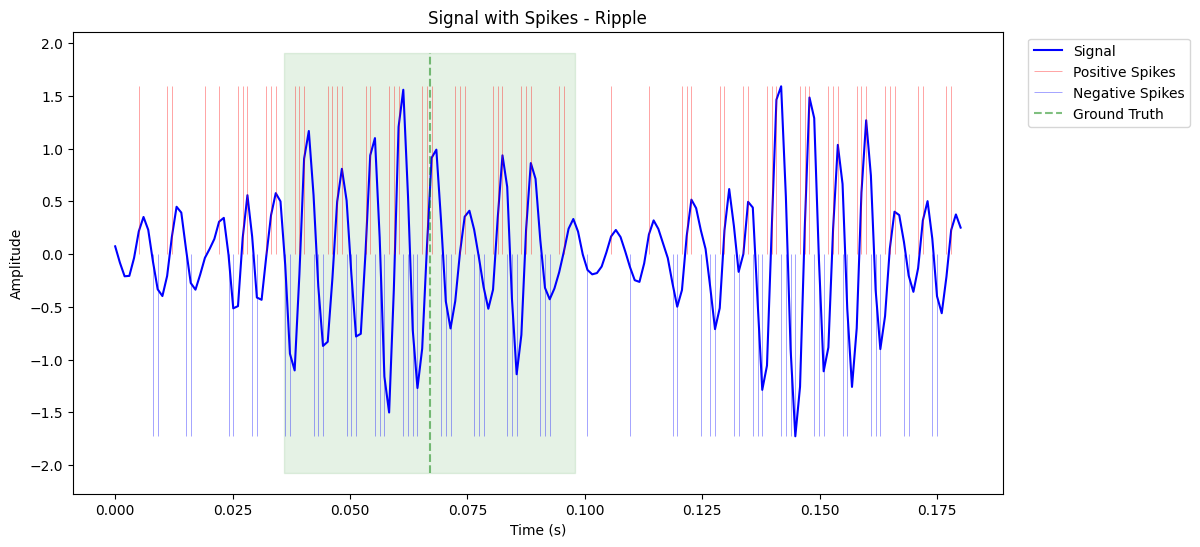

Total Spikes: 128.0
Up Spikes: 65.0
Down Spikes: 63.0


In [57]:
from snnTorch.utils.util import window_plot
window=0
plot_spikes=sorted_spikes[window,:,:]
# plot_filtered_window=sorted_filtered_windows[window,::factor]
plot_filtered_window=average_downsampling(sorted_filtered_windows[window,:], factor)
# plot_filtered_window=decimation_downsampling(sorted_filtered_windows[window,:], factor)


plot_gt=sorted_gt[window]
window_plot(plot_filtered_window,plot_spikes, plot_gt,downsampled_fs=1000,detection_window=RIPPLE_DETECTION_OFFSET)
up_spikes_window = np.sum(plot_spikes[:, 0])    # Sum along time axis
down_spikes_window = np.sum(plot_spikes[:, 1])  # Sum along time axis
print("Total Spikes:",up_spikes_window+down_spikes_window)
print("Up Spikes:",sorted_up_spikes_per_window[window])
print("Down Spikes:",sorted_down_spikes_per_window[window])

In [58]:
is_hfo = windowed_gt >= 0
hfo_windows = windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [59]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(windowed_input_data)

# Print the average counts
average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")


Average HFO Up Counts: 18.03263956593616
Average HFO Down Counts: 18.427323979483702
Average Total HFO Counts: 36.45996354541986
Average Non-HFO Up Counts: 7.913391408288711
Average Non-HFO Down Counts: 7.956714815368204
Average Total Non-HFO Counts: 15.870106223656915
Average Total Counts: 17.430050099556812


In [60]:
def get_isi(spike_train):
    times_up = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_down = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_total= np.concatenate((times_up, times_down))
    times_total.sort()  # sort the spike times
    if len(times_total) < 2:
        return np.array([])  # no ISI to compute
    return np.diff(times_total)

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


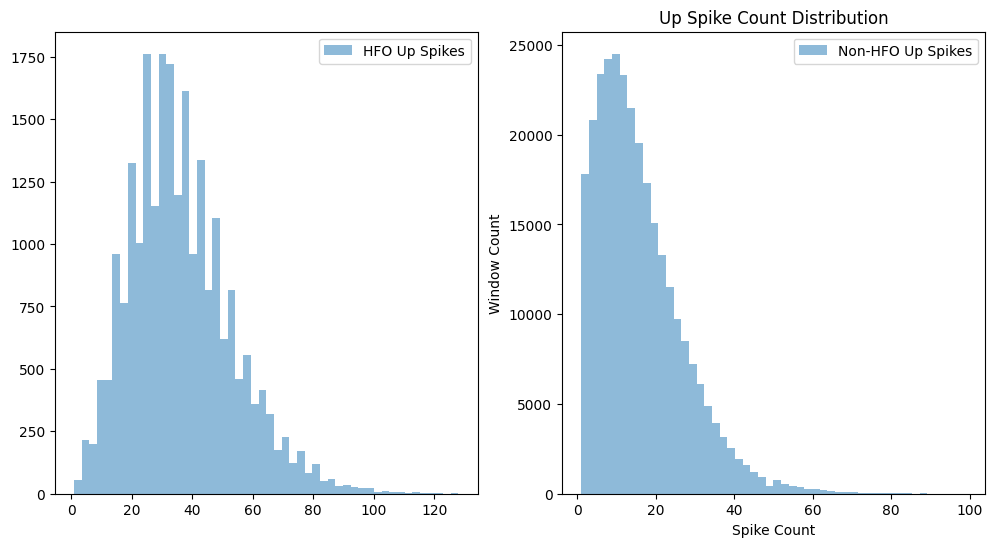

In [63]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

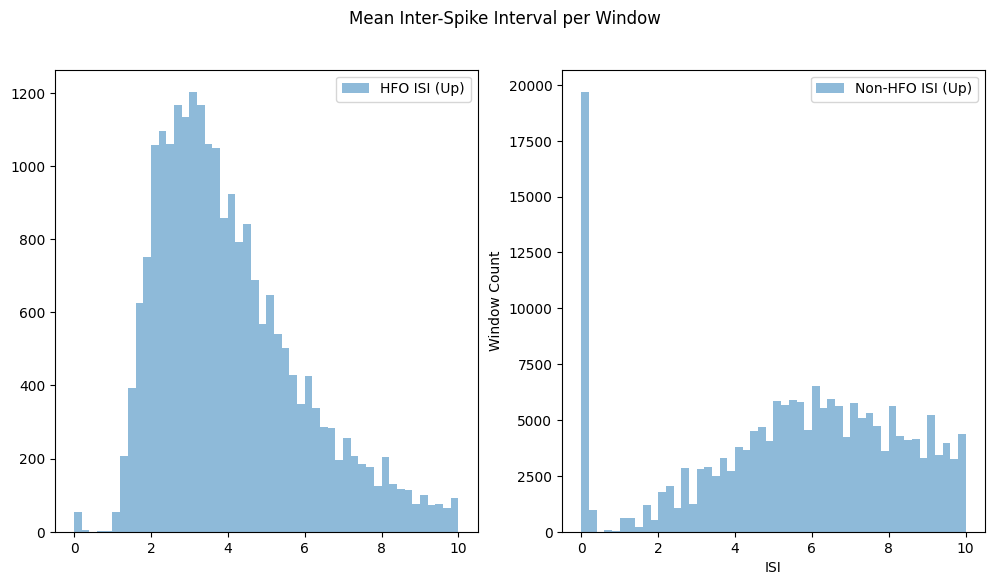

In [64]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

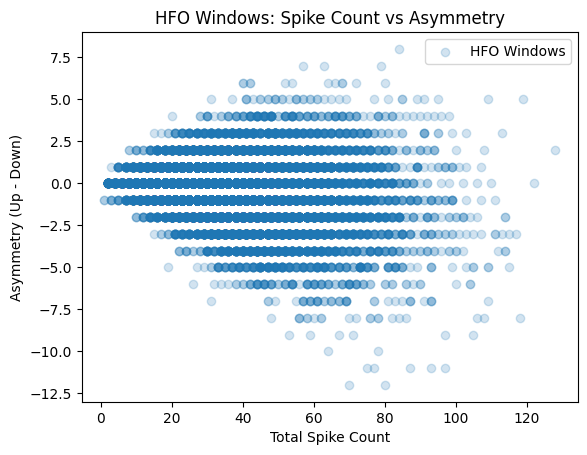

In [66]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts
plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.2, label='HFO Windows')

# plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## Process Windows

In [19]:
p1_windowed_input_data,p1_windowed_gt,p1_ripple_ids=only_some_channels_per_ripple(windowed_input_data,windowed_gt,ripple_ids,3)


In [20]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(p1_windowed_gt, return_counts=True)}")



GT_HFO_MASK = p1_windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / p1_windowed_gt.shape[0] * 100:.2f}%")



Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([287789,     41,     42,     39,     56,     71,     43,     54,     58,     60,     62,
           47,     76,     77,     46,     75,     77,     54,     65,     61, ...,     13,     17,
           10,     14,     15,     16,      6,     10,      5,     13,      4,      3,      1,
            6,      5,      4,      4,      8,      4,      5], dtype=int64))
Number of windows with an HFO: 8105
Percentage of windows with an HFO: 2.74%


In [21]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(p1_windowed_input_data[:, :, 0], axis=1) + np.sum(p1_windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = p1_windowed_input_data[sorted_indices]
sorted_gt= p1_windowed_gt[sorted_indices]
sorted_ripples=p1_ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [289898 291077 289899 290141 290042 290891 289157 294967 291078 289158 290765 294968 291137 289169
 290216 288428 287990 290861 289170 288429 ...  76056 135189 266954 220875 268332 191845  98607
 163174 278270 105850 244050 127067 210488  62088 198258 115027  40882 234644 115038 126627]
Sorted_data: (295894, 180, 2) | Sorted_gt: (295894,)
Sorted_gt preview: [ 67. 115.  67. 111. 129. 148.  42.  33. 115.  42.]
GT first window: 67.0 | GT last window: -1.0


In [22]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")

Sorted GT Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 140., 141., 142., 143., 144., 145., 146., 148., 150.,
       151., 152., 153., 157., 159., 160., 163., 164., 167., 170., 176.], dtype=float32), array([289,   1,   8,   7,   8,   6,  10,   3,   6,   4,  11,   5,  11,   8,  13,   2,   4,   4,
         4,   6, ...,   3,   2,   1,   2,   1,   5,   7,   5,   5,   1,   7,   6,   2,   3,   6,
         1,   3,   2,   3,   1], dtype=int64))


In [23]:
is_hfo = p1_windowed_gt >= 0
hfo_windows = p1_windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = p1_windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [ ]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(p1_windowed_input_data)

print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

Average HFO Up Counts: 22.272054287476866
Average HFO Down Counts: 22.907711289327576
Average Total HFO Counts: 45.17976557680444
Average Non-HFO Up Counts: 7.913391408288711
Average Non-HFO Down Counts: 7.956714815368204
Average Total Non-HFO Counts: 15.870106223656915
Average Total Counts: 15.843740766908601


In [25]:
# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


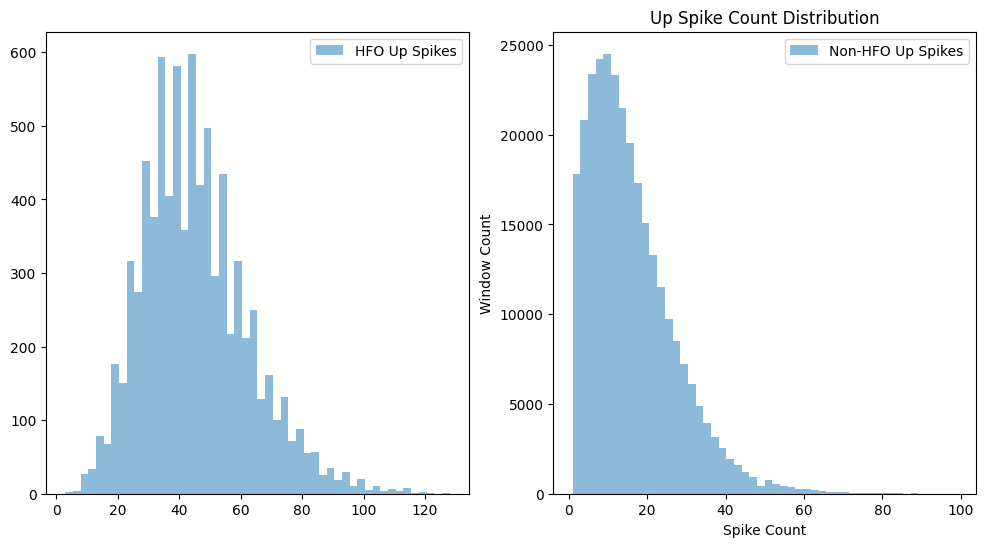

In [26]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

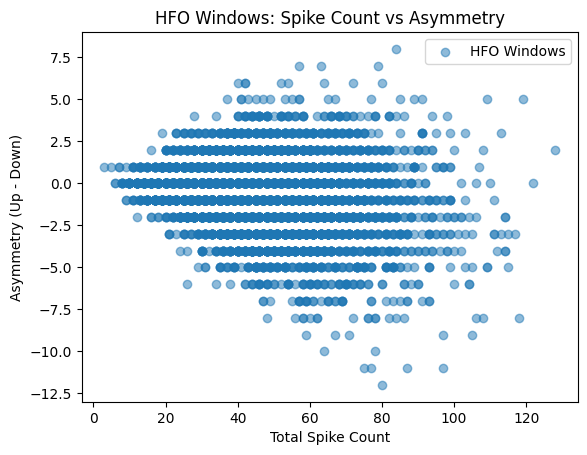

In [27]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
# plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## Process - Remove Windows above thresholds

In [28]:
thresholds=[average_total_counts*1.5,average_total_counts*2/3]
p2_windowed_input_data,p2_windowed_gt,p2_ripple_ids=min_max_spike_threshold(p1_windowed_input_data,p1_windowed_gt,
                                                                         p1_ripple_ids,MEAN_DETECTION_OFFSET,thresholds)

False Negative Removed - Number of Spikes:  25.0
False Negative Removed - Number of Spikes:  27.0
False Negative Removed - Number of Spikes:  27.0
False Negative Removed - Number of Spikes:  34.0
False Negative Removed - Number of Spikes:  32.0
False Negative Removed - Number of Spikes:  36.0
False Negative Removed - Number of Spikes:  40.0
False Negative Removed - Number of Spikes:  32.0
False Negative Removed - Number of Spikes:  36.0
False Negative Removed - Number of Spikes:  34.0
False Negative Removed - Number of Spikes:  41.0
False Negative Removed - Number of Spikes:  25.0
False Negative Removed - Number of Spikes:  51.0
False Negative Removed - Number of Spikes:  24.0
False Negative Removed - Number of Spikes:  27.0
False Negative Removed - Number of Spikes:  35.0
False Negative Removed - Number of Spikes:  37.0
False Negative Removed - Number of Spikes:  24.0
False Negative Removed - Number of Spikes:  35.0
False Negative Removed - Number of Spikes:  50.0
False Negative Remov

In [29]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(p2_windowed_gt, return_counts=True)}")



GT_HFO_MASK = p2_windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / p2_windowed_gt.shape[0] * 100:.2f}%")

Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([226294,     26,     36,     32,     49,     44,     41,     42,     46,     49,     46,
           29,     58,     66,     39,     57,     58,     39,     52,     50, ...,      9,     15,
           10,     13,     12,     16,      3,     10,      4,     13,      4,      3,      1,
            6,      5,      4,      3,      8,      3,      4], dtype=int64))
Number of windows with an HFO: 6448
Percentage of windows with an HFO: 2.77%


In [30]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(p2_windowed_input_data[:, :, 0], axis=1) + np.sum(p2_windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = p2_windowed_input_data[sorted_indices]
sorted_gt= p2_windowed_gt[sorted_indices]
sorted_ripples=p2_ripple_ids[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [228144 229124 228145 228351 228265 227487 228954 228849 231905 227488 229125 229178 231906 227499
 226485 228412 226866 228926 231907 227500 ... 160975 139047 164394  44134  85991 152562 222923
 112077  25674 102024  33963 103289  61250 176691  96448   2502 118783  96443 225458 113411]
Sorted_data: (232742, 180, 2) | Sorted_gt: (232742,)
Sorted_gt preview: [ 67. 115.  67. 111. 129.  42. 148.  82.  33.  42.]
GT first window: 67.0 | GT last window: -1.0


In [31]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")

Sorted GT Distribution: (array([ 31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50., ..., 143., 144., 145., 146., 148., 149., 150., 151., 152.,
       153., 156., 157., 159., 160., 162., 163., 164., 167., 170., 176.], dtype=float32), array([ 6, 10, 10, 11,  9, 16,  4,  9,  8, 13,  7, 14, 12, 16,  5,  7,  7,  9, 12,  8, ...,  2,  3,
        7,  7,  8,  1,  5,  2, 10,  6,  1,  2,  3,  6,  1,  1,  4,  2,  3,  3], dtype=int64))


In [32]:
is_hfo = p2_windowed_gt >= 0
hfo_windows = p2_windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = p2_windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [ ]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(p2_windowed_input_data)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

Average HFO Up Counts: 24.099410669975185
Average HFO Down Counts: 24.84010545905707
Average Total HFO Counts: 48.939516129032256
Average Non-HFO Up Counts: 5.6282358347989785
Average Non-HFO Down Counts: 5.645403766781267
Average Total Non-HFO Counts: 11.273639601580244
Average Total Counts: 9.20649688483525


In [34]:
# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])

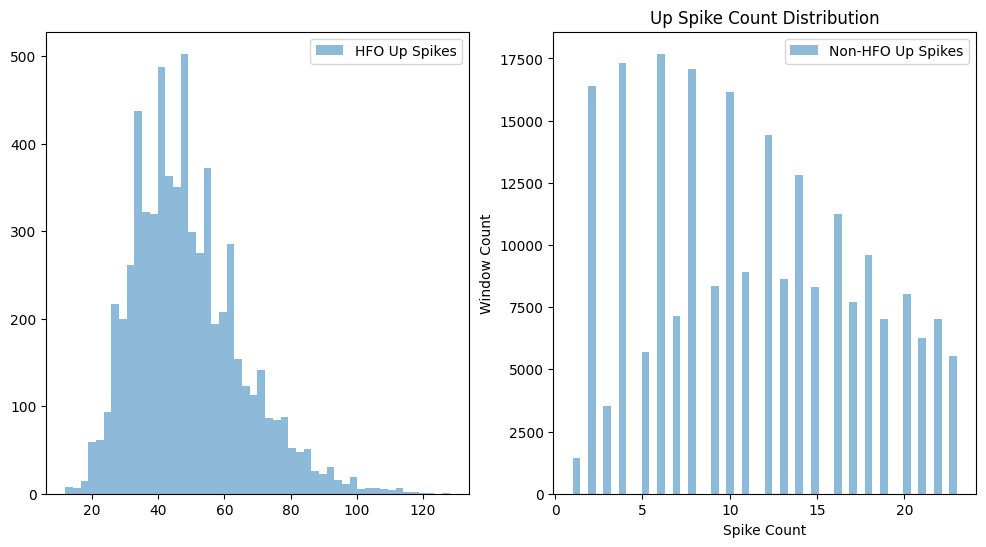

In [35]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

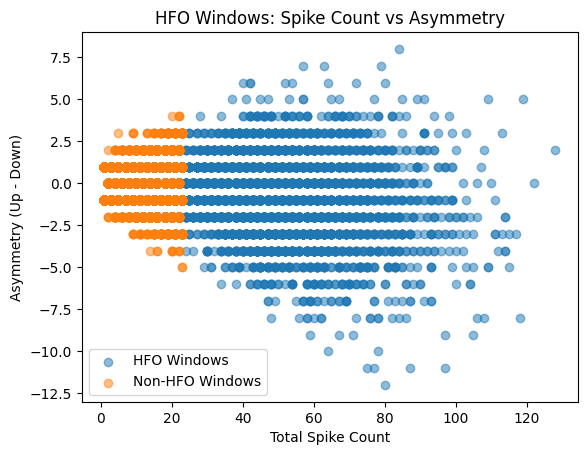

In [36]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

## After Undersampling Non-Ripples

In [69]:
from snnTorch.utils.training import undersample_majority, oversample_minority
intermediate_input, intermediate_gt = windowed_input_data, windowed_gt  # Default: No Balancing
balance=True
if balance:
    intermediate_input, intermediate_gt = undersample_majority(windowed_input_data, windowed_gt, GT_HFO_MASK)  

# Print the number of samples in each class
print(f"Intermediate GT Class Distribution: {np.unique(intermediate_gt, return_counts=True)}")
print(f"Intermediate Window Input Data Shape: {intermediate_input.shape}")


Intermediate GT Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([23591,   144,   184,   158,   184,   239,   168,   176,   192,   216,   232,   160,   247,
         232,   160,   240,   248,   160,   200,   176, ...,    72,   136,    80,    73,    96,
          80,    48,    56,    40,    56,    40,    16,    40,    16,    40,    32,    32,    40,
          24,    32], dtype=int64))
Intermediate Window Input Data Shape: (47182, 180, 2)


In [72]:
is_hfo= intermediate_gt >= 0
hfo_windows = intermediate_input[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = intermediate_input[~is_hfo]  # shape: (N_nonHFO, 180, 2)
print(f"Number of HFO windows: {hfo_windows.shape[0]}")
print(f"Number of Non-HFO windows: {non_hfo_windows.shape[0]}")

Number of HFO windows: 23591
Number of Non-HFO windows: 23591


In [73]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
average_total_counts= (np.sum(total_hfo_counts)+np.sum(total_nonhfo_counts))/len(intermediate_input)

print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")
print(f"Average Total Counts: {average_total_counts}")

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


Average HFO Up Counts: 18.03263956593616
Average HFO Down Counts: 18.427323979483702
Average Total HFO Counts: 36.45996354541986
Average Non-HFO Up Counts: 7.964605146030266
Average Non-HFO Down Counts: 8.005595354160485
Average Total Non-HFO Counts: 15.970200500190751
Average Total Counts: 26.21508202280531


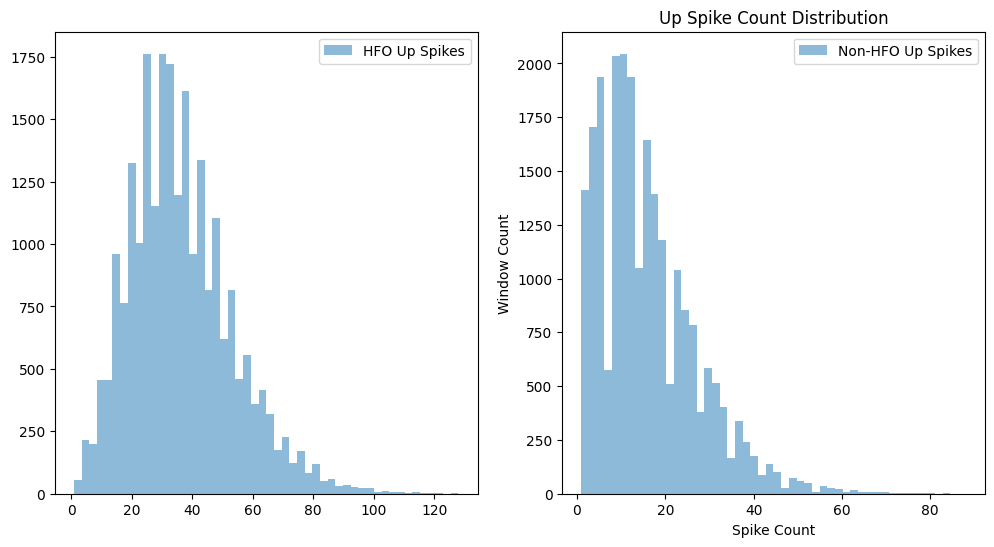

In [74]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50, alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

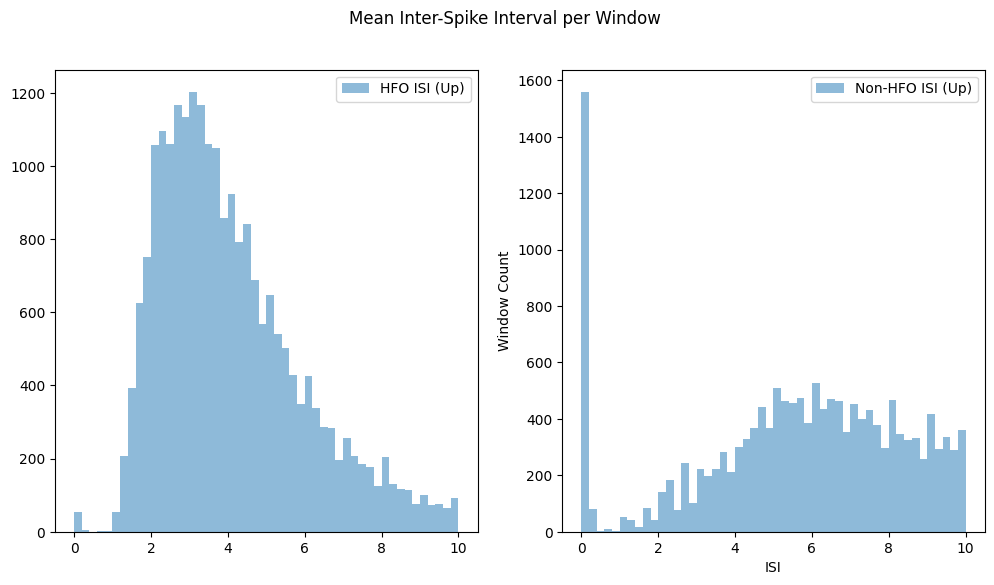

In [75]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

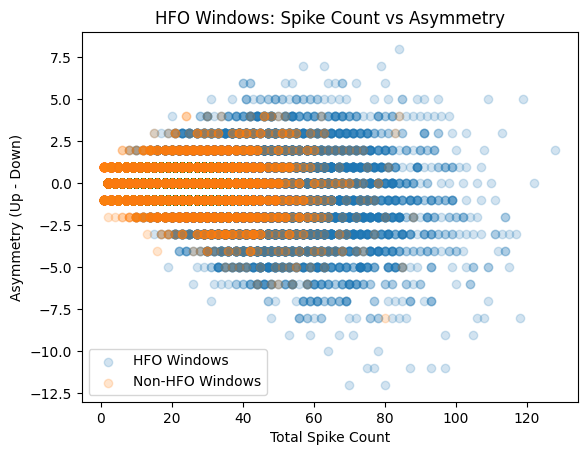

In [77]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.2, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.2, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

In [44]:
# Save the windowed 
# input data and ground truth to a file
save=False
if save:
    windowed_save=os.path.join(curr_dir,"windowed_data")
    os.makedirs(windowed_save, exist_ok=True)
    np.save(os.path.join(windowed_save, "filtered_windows.npy"), filtered_windows, allow_pickle=True)
    np.save(os.path.join(windowed_save, "windowed_input_data.npy"), windowed_input_data, allow_pickle=True)
    np.save(os.path.join(windowed_save,"windowed_gt.npy"), windowed_gt, allow_pickle=True)
    # Save the configuration to a JSON file
    with open(os.path.join(windowed_save, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)